# ($\epsilon$, $\delta$)-Differentially Private PLS on NIR of Corn

Author: Ramin Nikzad-Langerodi

This notebook contains accomponying code for the paper "$(\epsilon, \delta)$-Differentially Private Partial Least Squares Regression" by Ramin Nikzad-Langerodi, Du Nguyen Duy, Mohit Kumar and Mathab Alghasi (2024).

In [1]:
# Imports
!pip install chemotools
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from chemotools.baseline import AirPls
from chemotools.scatter import MultiplicativeScatterCorrection
from chemotools.derivative import SavitzkyGolay

# EDPLS
from diPLSlib.models import EDPLS

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

  Using cached chemotools-0.1.5-py3-none-any.whl.metadata (5.1 kB)
Using cached chemotools-0.1.5-py3-none-any.whl (7.5 MB)
   ---------------------------------------- 0.0/35.6 MB ? eta -:--:--
   - -------------------------------------- 1.3/35.6 MB 9.0 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/35.6 MB 9.1 MB/s eta 0:00:04
   ------- -------------------------------- 6.8/35.6 MB 11.8 MB/s eta 0:00:03
   ---------- ----------------------------- 9.2/35.6 MB 11.6 MB/s eta 0:00:03
   ------------- -------------------------- 11.8/35.6 MB 11.7 MB/s eta 0:00:03
   --------------- ------------------------ 13.9/35.6 MB 11.7 MB/s eta 0:00:02
   ------------------- -------------------- 17.0/35.6 MB 11.8 MB/s eta 0:00:02
   ---------------------- ----------------- 19.7/35.6 MB 11.9 MB/s eta 0:00:02
   ------------------------ --------------- 22.0/35.6 MB 11.8 MB/s eta 0:00:02
   --------------------------- ------------ 24.6/35.6 MB 11.8 MB/s eta 0:00:01
   --------------------

### Data Set
We will use the Corn data set from Eigenvector Research Inc. The data set contains NIR spectra of corn samples recorded on different infrared spectroscopy instruments along with moisture, oil, protein and starch contents. The data set is available at https://www.eigenvector.com/data/Corn/. 

In [19]:
# Load data
data = sio.loadmat('../data/corn.mat')

# Spectra & Reference values
X = data['m5spec'][0][0]['data']
y = data['propvals'][0][0]['data'][:, 0].reshape(-1, 1)

# Wavelengths
wn = data['m5spec'][0][0][9][1][0][0]

### Accuracy-Pricacy Tradeoff

$(\epsilon, \delta)$-differentially private PLS models with a fixed number of LVs are training with different values of $\epsilon$.


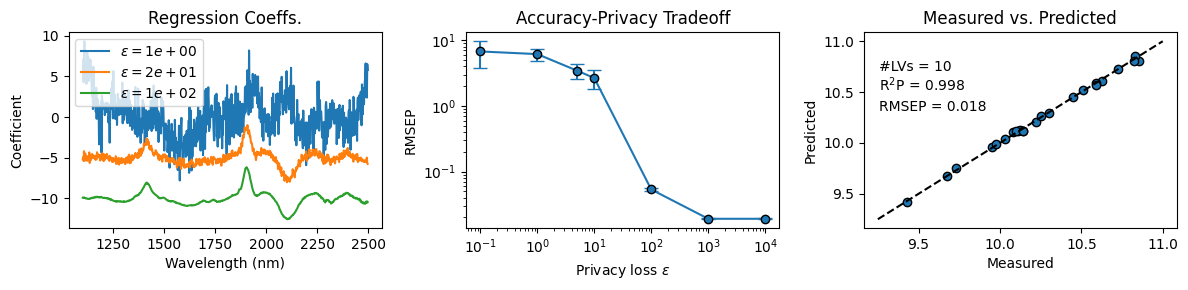

In [24]:
# Preliminaries
eps = [1, 25, 100]                             # epsilon values
bo = 0                                         # baseline offset for plotting
ncomps=10                                      # number of components

# Result arrays
EPS=[]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

plt.figure(figsize=(12, 3))
plt.subplot(131)

# Loop over epsilon values
for i in eps:
    
    m = EDPLS(ncomps, epsilon=i, delta=0.05)
    m.fit(X_train, y_train)

    # Compute RMSEP
    ypred = m.predict(X_test)

    # Plot regression coefficients
    plt.plot(wn, m.coef_ + bo)

    EPS.append(f'$\epsilon = {i:.0e}$')
    bo -= 5

plt.legend(EPS)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient')
plt.title('Regression Coeffs.')


### Accuracy-privacy trade-off
plt.subplot(132)
# Define the number of repetitions
num_repetitions = 100

eps = [0.1, 1, 5, 10, 100, 1000, 10000]

# Initialize arrays to store results
rmsep_results = np.zeros((num_repetitions, len(eps)))
yvar_results = np.zeros((num_repetitions, len(eps)))

# Repeat the experiment 100 times
for rep in range(num_repetitions):
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    RMSEP = []
    for i, epsilon in enumerate(eps):
        m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
        m.fit(X_train, y_train)

        # Compute RMSEP
        ypred = m.predict(X_test)
        rmsep = np.sqrt(rmse(y_test, ypred))
        RMSEP.append(rmsep)

    # Store results for this repetition
    rmsep_results[rep, :] = RMSEP

# Compute means and standard errors
rmsep_mean = np.mean(rmsep_results, axis=0)
rmsep_std = np.std(rmsep_results, axis=0) / np.sqrt(num_repetitions)

# Plot the results
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
blue = default_colors[0]
orange = default_colors[1]

# Plot RMSEP
r = plt.errorbar(eps, rmsep_mean, yerr=rmsep_std, fmt='o-', capsize=5, label='RMSEP', color=blue, mec='k')
#r = plt.plot(eps, rmsep_mean, 'o-', label='RMSEP', color=blue, mec='k')
plt.xlabel('Privacy loss $\epsilon$')
plt.ylabel('RMSEP')
plt.title('RMSEP vs. $\epsilon$')
plt.semilogx()
plt.semilogy()
plt.title('Accuracy-Privacy Tradeoff')


### True vs Predicted (PLS baseline)
plt.subplot(133)

pls = PLSRegression(n_components=ncomps, scale=False)
pls.fit(X_train, y_train)
ypred = pls.predict(X_test)
plt.scatter(y_test, ypred, edgecolors='k', label='PLS/' + f'R2P =' + str(np.round(r2_score(y_test, ypred),3)))

# Compute R2 score
r2p = r2_score(y_test, ypred)	
rmsep = np.sqrt(rmse(y_test, ypred))

# Annotate the plot
plt.annotate(f'#LVs = {ncomps}', (0.05, 0.8), xycoords='axes fraction')
plt.annotate(f'R$^2$P = {r2p:.3f}', (0.05, 0.7), xycoords='axes fraction')
plt.annotate(f'RMSEP = {rmsep:.3f}', (0.05, 0.6), xycoords='axes fraction')

plt.plot([9.25, 11], [9.25, 11], 'k--')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted')

plt.tight_layout()

plt.show()

### Optimization of the number of LVs given $\epsilon$ and $\delta$


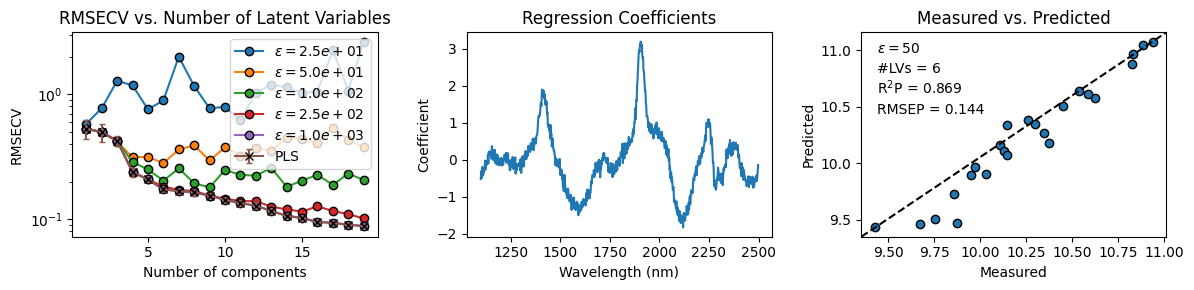

In [23]:
# Define the range of epsilon values
epsilon_values = [25, 50, 100, 250, 1000]

results = {}

model = EDPLS(8, epsilon=1, delta=0.05)

# Define the parameter grid
param_grid = {
    'A': np.arange(1, 20)
}

plt.figure(figsize=(12, 3))
plt.subplot(131)
# Loop over the epsilon values
for epsilon in epsilon_values:

    # Initialize the model with the current epsilon
    model = EDPLS(8, epsilon=epsilon, delta=0.05)

    # Define the GridSearchCV object
    gs = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')

    # Fit the model
    gs.fit(X_train, y_train)

    # Store the results
    results[epsilon] = {
        'param_A': gs.cv_results_['param_A'],
        'mean_test_score': gs.cv_results_['mean_test_score'],
        'std_test_score': gs.cv_results_['std_test_score']
    }


# Plot results
for epsilon in epsilon_values:
    mean_rmse = np.sqrt(-results[epsilon]['mean_test_score'])
    std_rmse = results[epsilon]['std_test_score']
    epsilon_sci = "{:.1e}".format(epsilon)
    #plt.errorbar(results[epsilon]['param_A'], mean_rmse, yerr=std_rmse, fmt='o-', label=f'$\epsilon = {epsilon_sci}$', capsize=2.5, mec='k')
    plt.plot(results[epsilon]['param_A'], mean_rmse, 'o-', label=f'$\epsilon = {epsilon_sci}$', mec='k')

# Compare with PLS
param_grid = {
    'n_components': np.arange(1, 20)
}

pls = GridSearchCV(PLSRegression(scale=False), param_grid, cv=10, scoring='neg_root_mean_squared_error')
pls.fit(X_train, y_train)

# Store the results
results_pls = {
    'param_n_components': pls.cv_results_['param_n_components'],
    'mean_test_score': pls.cv_results_['mean_test_score'],
    'std_test_score': pls.cv_results_['std_test_score']
}
mean_rmse = np.sqrt(-results_pls['mean_test_score'])
std_rmse = results_pls['std_test_score']
plt.errorbar(results_pls['param_n_components'], mean_rmse, yerr=std_rmse, fmt='x-', capsize=2.5, mec='k', label='PLS')

plt.xlabel('Number of components')
plt.ylabel('RMSECV')
plt.semilogy()
plt.title('RMSECV vs. Number of Latent Variables')
plt.legend(loc='upper right')

### EDPLS model with epsilon = 100
epsilon = 50
ncomps =  int(np.where(-results[epsilon]['mean_test_score'] == np.min(-results[epsilon]['mean_test_score']))[0] + 1)

m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
m.fit(X_train, y_train)

# Compute RMSEP
ypred = m.predict(X_test)
rmsep = np.sqrt(rmse(y_test, ypred))
r2p = r2_score(y_test, ypred)


# Plot the regression coefficients
plt.subplot(132)
plt.plot(wn, m.coef_)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients')

# Measured vs. Predicted plot
plt.subplot(133)
plt.scatter(y_test, ypred, edgecolors='k')

# Annotate the plot
plt.annotate(f'$\epsilon = {epsilon}$', (0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'#LVs = {ncomps}', (0.05, 0.8), xycoords='axes fraction')
plt.annotate(f'R$^2$P = {r2p:.3f}', (0.05, 0.7), xycoords='axes fraction')
plt.annotate(f'RMSEP = {rmsep:.3f}', (0.05, 0.6), xycoords='axes fraction')

plt.plot([0, 1], [0, 1], 'k--', transform=plt.gca().transAxes)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted')
plt.tight_layout()

Achieving strong privacy guarantees (i.e., $\epsilon \leq  10$) on raw Corn spectra is difficult, due to a high privacy-accuracy trade-off.

### Effect of spectral preprocessing on privacy-accuracy trade-off

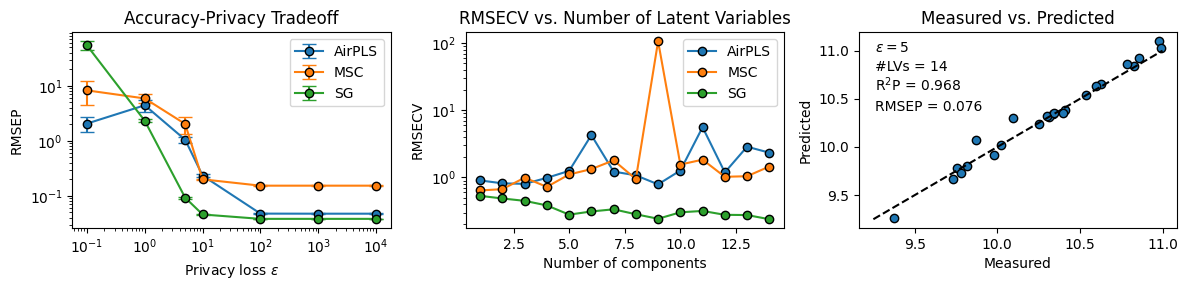

In [26]:
# Create preprocessed datasets
airpls = AirPls()                                                           # Baseline correction
X_airpls = airpls.fit_transform(X)

msc = MultiplicativeScatterCorrection()                                     # Multiplicative scatter correction
X_msc = msc.fit_transform(X)

sg = SavitzkyGolay(window_size=15, polynomial_order=2, derivate_order=1)    # Savitzky-Golay derivative
X_sg = sg.fit_transform(X)

datasets = {'AirPLS': X_airpls, 'MSC': X_msc, 'SG': X_sg}

# Define the number of repetitions
num_repetitions = 100

eps = [0.1, 1, 5, 10, 100, 1000, 10000]
ncomps = 7

plt.figure(figsize=(12, 3))
plt.subplot(131)

for dataset_name, X_transformed in datasets.items():
    # Initialize arrays to store results
    rmsep_results = np.zeros((num_repetitions, len(eps)))

    # Repeat the experiment 100 times
    for rep in range(num_repetitions):
        
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3)

        RMSEP = []
        for i, epsilon in enumerate(eps):
            m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)
            m.fit(X_train, y_train)

            # Compute RMSEP
            ypred = m.predict(X_test)
            rmsep = np.sqrt(rmse(y_test, ypred))
            RMSEP.append(rmsep)

        # Store results for this repetition
        rmsep_results[rep, :] = RMSEP

    # Compute means and standard errors
    rmsep_mean = np.mean(rmsep_results, axis=0)
    rmsep_std = np.std(rmsep_results, axis=0) / np.sqrt(num_repetitions)

    # Plot the results
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    blue = default_colors[0]
    orange = default_colors[1]

    # Plot RMSEP
    r = plt.errorbar(eps, rmsep_mean, yerr=rmsep_std, fmt="o-", capsize=5, label=dataset_name, mec='k')


plt.xlabel('Privacy loss $\epsilon$')
plt.ylabel('RMSEP')
plt.title('RMSEP vs. $\epsilon$')
plt.semilogx()
plt.semilogy()
plt.title('Accuracy-Privacy Tradeoff')
plt.legend()

# GridSearchCV for epsilon=1 for all datasets
plt.subplot(132)

epsilon=5

results = {}
model = EDPLS(8, epsilon=1, delta=0.05)

# Define the parameter grid
param_grid = {
    'A': np.arange(1, 15)
}

# Loop over the datasets
for dataset_name, X_transformed in datasets.items():

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3)

    # Initialize the model with the current epsilon
    model = EDPLS(8, epsilon=epsilon, delta=0.05)

    # Define the GridSearchCV object
    gs = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')

    # Fit the model
    gs.fit(X_train, y_train)

    # Store the results
    results[(dataset_name)] = {
        'param_A': gs.cv_results_['param_A'],
        'mean_test_score': gs.cv_results_['mean_test_score'],
        'std_test_score': gs.cv_results_['std_test_score']
    }

# Plot results
for dataset_name in datasets.keys():

    mean_rmse = np.sqrt(-results[(dataset_name)]['mean_test_score'])
    std_rmse = results[(dataset_name)]['std_test_score']
    plt.plot(results[(dataset_name)]['param_A'], mean_rmse, 'o-', label=f'{dataset_name}', mec='k')

plt.xlabel('Number of components')
plt.ylabel('RMSECV')
plt.semilogy()
plt.title('RMSECV vs. Number of Latent Variables')
plt.legend(loc='upper right')


# Plot measured vs predicted values for SG dataset
# at epsilon = 5 and optimal Nr of LVs 
plt.subplot(133)

epsilon = 5
ncomps = int(np.where(-results['SG']['mean_test_score'] == np.min(-results['SG']['mean_test_score']))[0] + 1)

m = EDPLS(ncomps, epsilon=epsilon, delta=0.05)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sg, y, test_size=0.3) 

m.fit(X_train, y_train)
ypred = m.predict(X_test)
rmsep = np.sqrt(rmse(y_test, ypred))
r2p = r2_score(y_test, ypred)

plt.scatter(y_test, ypred, edgecolors='k', label=dataset_name)

plt.plot([9.25, 11], [9.25, 11], 'k--')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs. Predicted')

# Annotate the plot
plt.annotate(f'$\epsilon = {epsilon}$', (0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'#LVs = {ncomps}', (0.05, 0.8), xycoords='axes fraction')
plt.annotate(f'R$^2$P = {r2p:.3f}', (0.05, 0.7), xycoords='axes fraction')
plt.annotate(f'RMSEP = {rmsep:.3f}', (0.05, 0.6), xycoords='axes fraction')
plt.tight_layout()

Savitzky-Golay based (1st derivative) spectral pre-processing imporoves the privacy-accuracy trade-off markedly. The model now exhibits strong privacy guarantees ($\epsilon \leq 10$) with a reasonable accuracy. 